In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import NuSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from re import X


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Initial exploration of the dataset

---



In [3]:
df_train = pd.read_csv("/content/drive/MyDrive/EE559/Project/Mushroom_datasets/mushroom_train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/EE559/Project/Mushroom_datasets/mushroom_test.csv")

In [ ]:
train_df = pd.read_csv("/content/mushroom_train.csv")
test_df = pd.read_csv("/content/mushroom_test.csv")

In [4]:
df_train.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season,class
0,4.98,c,i,y,f,a,c,n,6.04,6.21,w,f,f,d,a,p
1,2.84,x,y,y,f,a,c,w,5.66,3.55,y,t,r,h,u,p
2,11.44,x,y,y,f,a,c,w,7.03,25.29,n,t,e,d,w,e
3,8.77,s,t,r,t,d,c,g,4.44,13.61,r,f,f,d,a,p
4,7.55,x,d,n,t,p,c,y,8.41,18.44,y,f,f,d,a,e


In [5]:
df_train.describe()

,cap-diameter,stem-height,stem-width
count,42748.000000,42748.000000,42748.000000
mean,6.714149,6.583224,12.117692
std,5.220008,3.368333,10.004874
min,0.380000,0.000000,0.000000
25%,3.480000,4.640000,5.180000
50%,5.865000,5.960000,10.200000
75%,8.530000,7.750000,16.540000
max,62.340000,33.920000,103.910000


In [6]:
df_test.describe()

,cap-diameter,stem-height,stem-width
count,18321.000000,18321.000000,18321.000000
mean,6.779834,6.577604,12.223417
std,5.367869,3.374032,10.107991
min,0.440000,0.000000,0.000000
25%,3.490000,4.630000,5.260000
50%,5.860000,5.940000,10.160000
75%,8.580000,7.720000,16.660000
max,58.300000,33.720000,102.480000


In [7]:
cols = list(df_train.columns)
cols.remove('cap-diameter')
cols.remove('stem-height')
cols.remove('stem-width')
for col in cols:
  print(f"Unique values and value counts for {col}:")
  print(df_train[col].value_counts())
  print("-"*100)

Unique values and value counts for cap-shape:
x    18808
f     9289
s     5079
b     4043
o     2417
p     1824
c     1288
Name: cap-shape, dtype: int64
----------------------------------------------------------------------------------------------------
Unique values and value counts for cap-surface:
t    15569
s     5341
y     4460
h     3482
g     3280
d     3125
e     1789
k     1602
i     1599
w     1494
l     1007
Name: cap-surface, dtype: int64
----------------------------------------------------------------------------------------------------
Unique values and value counts for cap-color:
n    16960
y     6026
w     5402
g     3072
e     2781
o     2581
r     1227
u     1181
p     1161
k      907
b      870
l      580
Name: cap-color, dtype: int64
----------------------------------------------------------------------------------------------------
Unique values and value counts for does-bruise-or-bleed:
f    35279
t     7469
Name: does-bruise-or-bleed, dtype: int64
---------------

In [8]:
categorical_cols_names = ['cap-shape', 'cap-surface', 'cap-color', 
                            'does-bruise-or-bleed', 'gill-attachment', 
                            'gill-spacing', 'gill-color','stem-color', 
                            'has-ring', 'ring-type', 'habitat', 'season']

cols_vals = {}
for col in categorical_cols_names:
  print(f"Number of unique values in {col}: {len(df_train[col].unique())}")
  cols_vals[col] = len(df_train[col].unique())

Number of unique values in cap-shape: 7
Number of unique values in cap-surface: 11
Number of unique values in cap-color: 12
Number of unique values in does-bruise-or-bleed: 2
Number of unique values in gill-attachment: 7
Number of unique values in gill-spacing: 3
Number of unique values in gill-color: 12
Number of unique values in stem-color: 13
Number of unique values in has-ring: 2
Number of unique values in ring-type: 8
Number of unique values in habitat: 8
Number of unique values in season: 4


# Functions

---

In [9]:
def onehotencode(training_data):

  cat_cols = ['cap-shape','cap-surface','cap-color','does-bruise-or-bleed','gill-attachment','gill-spacing','gill-color','stem-color','has-ring','ring-type','habitat','season']
  num_cols = ['cap-diameter','stem-height','stem-width','class']

  train_data = training_data[cat_cols]
  one_hot_encoded_data = pd.get_dummies(train_data)
  train_num_data = training_data[num_cols]
  df_train = pd.concat([one_hot_encoded_data, train_num_data], axis=1)

  return df_train

In [10]:
def labels(data_train_labels):

  train_labels = np.zeros(data_train_labels.shape)
  for j in range(data_train_labels.shape[0]):
    if data_train_labels[j] == 'e':
      train_labels[j] = 1
    else:
      train_labels[j] = 0
  
  return train_labels

In [11]:
def dataset(training_data, testing_data):

  df_train = onehotencode(training_data)
  df_test = onehotencode(testing_data)

  data_train_values = df_train.values
  data_test_values = df_test.values

  data_train_labels = data_train_values[:,-1]
  data_test_labels = data_test_values[:,-1]

  train_labels = labels(data_train_labels)
  test_labels = labels(data_test_labels)

  return data_train_values, data_test_values, train_labels, test_labels

In [12]:
def one_hot_encoder(df_col, encoder):
  
  col = df_col.to_numpy()
  col = col.reshape(-1, 1)
  col_enc = encoder.fit_transform(col)
  col_arr = col_enc.toarray()

  return col_arr

In [13]:
def catTonum(df, cat_cols):
  encoder = OneHotEncoder()
  temp = []
  for col in cat_cols:
    temp.append(one_hot_encoder(df[col], encoder))
  
  data = np.hstack((temp[0], temp[1], temp[2], temp[3], temp[4], temp[5], temp[6], temp[7],
                  temp[8], temp[9], temp[10], temp[11]))

  return data


In [14]:
def pre_processing(df_train, df_test):
  train_labels = df_train['class'].apply(lambda x: 1 if x == 'e' else 0)
  test_labels = df_test['class'].apply(lambda x: 1 if x == 'e' else 0)

  numeric_cols_train = df_train[['cap-diameter', 'stem-height', 'stem-width']]
  numeric_cols_test = df_test[['cap-diameter', 'stem-height', 'stem-width']]

  categorical_cols_names = ['cap-shape', 'cap-surface', 'cap-color', 
                            'does-bruise-or-bleed', 'gill-attachment', 
                            'gill-spacing', 'gill-color','stem-color', 
                            'has-ring', 'ring-type', 'habitat', 'season']
  
  train_data = catTonum(df_train, categorical_cols_names)
  test_data = catTonum(df_test, categorical_cols_names)

  train_data = np.hstack((train_data, numeric_cols_train))
  test_data = np.hstack((test_data, numeric_cols_test))

  return train_data, train_labels, test_data, test_labels




In [15]:
def addColumns1(df, groupby_col, numeric_col, stat):

  categorical_cols_names = ['cap-shape', 'cap-surface', 'cap-color', 
                            'does-bruise-or-bleed', 'gill-attachment', 
                            'gill-spacing', 'gill-color','stem-color', 
                            'has-ring', 'ring-type', 'habitat', 'season']

  temp_df = df.copy()
  mean_df = temp_df.groupby([groupby_col])[numeric_col].agg(stat).reset_index()

  for index, row in mean_df.iterrows():
    temp_df[f'{index}_{stat}_{groupby_col}_{numeric_col}'] = 0
    temp_df.loc[(temp_df[groupby_col] == mean_df[groupby_col][index]), f'{index}_{stat}_{groupby_col}_{numeric_col}'] = mean_df[numeric_col][index]

  temp_df = temp_df.drop(columns=categorical_cols_names)
  train_labels = temp_df['class'].apply(lambda x: 1 if x == 'e' else 0)
  temp_df['labels'] = train_labels
  temp_df = temp_df.drop(columns=['class'])
  
  return temp_df



In [16]:
def addColumns2(df):

  categorical_cols_names = ['cap-shape', 'cap-surface', 'cap-color', 
                            'does-bruise-or-bleed', 'gill-attachment', 
                            'gill-spacing', 'gill-color','stem-color', 
                            'has-ring', 'ring-type', 'habitat', 'season']

  temp_df = df.copy()
  mean_df = temp_df.groupby(['stem-color', 'gill-attachment'])['stem-height'].agg('median').reset_index()

  for index, row in mean_df.iterrows():
    res = temp_df.loc[(temp_df['stem-color'] == mean_df['stem-color'][index]) & (df['gill-attachment'] == mean_df['gill-attachment'][index])]
    value = mean_df['stem-height'][index]
    res[f'avg_cd_sccs{index}'] = value
    temp_df[f'avg_cd_sccs{index}'] = 0
    temp_df.loc[(temp_df['stem-color'] == mean_df['stem-color'][index]) & (temp_df['gill-attachment'] == mean_df['gill-attachment'][index])] = res

  temp_df = temp_df.drop(columns=categorical_cols_names)
  train_labels = temp_df['class'].apply(lambda x: 1 if x == 'e' else 0)
  temp_df['labels'] = train_labels
  temp_df = temp_df.drop(columns=['class'])
  
  return temp_df



In [17]:
def genParams():
  categorical_cols_names = ['cap-shape', 'cap-surface', 'cap-color', 
                              'does-bruise-or-bleed', 'gill-attachment', 
                              'gill-spacing', 'gill-color','stem-color', 
                              'has-ring', 'ring-type', 'habitat', 'season']

  numeric_cols_names = ['cap-diameter', 'stem-height', 'stem-width']

  statistics = ['mean', 'max', 'min', 'median']

  params = []
  for i in categorical_cols_names:
    for j in numeric_cols_names:
      for k in statistics:
        params.append([i, j, k])
  
  return params


In [18]:
def decodeIndexes(indexes, df):
  categorical_cols_names = ['cap-shape', 'cap-surface', 'cap-color', 
                            'does-bruise-or-bleed', 'gill-attachment', 
                            'gill-spacing', 'gill-color','stem-color', 
                            'has-ring', 'ring-type', 'habitat', 'season']

  unique_col_vals = []
  for col in categorical_cols_names:
    unique_col_vals.append(df_train[col].unique().tolist())

  flattened_list = [item for sublist in unique_col_vals for item in (sublist if isinstance(sublist, list) else [sublist])]

  cols_vals = {}
  for col in categorical_cols_names:
    cols_vals[col] = len(df_train[col].unique())
  
  feats = []
  for index in indexes:
    if index == 89:
      feats.append("cap-diameter")
    elif index == 90:
      feats.append("stem-height")
    elif index == 91:
      feats.append("stem-width")
    else:
      count = 0
      for key, value in cols_vals.items():
        count += value
        if count >= index:
          feats.append(key)
          break

  features_map = {}
  for i in range(len(indexes)):
    if indexes[i] in [89, 90, 91]:
      features_map[i] = [feats[i], 0]
    else:
      features_map[i] = [feats[i], flattened_list[indexes[i]]]

  return features_map

In [19]:
def top3feats_of_poison_mushrooms(test_data, pred_val, original_indexes, df_train):

  cat_feat_map = {}
  for i in range(len(pred_val)):
    if pred_val[i] == 0:
      key = tuple(test_data[i])
      if key not in cat_feat_map:
        cat_feat_map[key] = 0
      else:
        cat_feat_map[key]+=1
  
  sorted_dict = dict(sorted(cat_feat_map.items(), key=lambda item: item[1], reverse=True))
  top_3 = list(sorted_dict.items())[:3]

  cat_inds = [i for i in original_indexes if i not in [89, 90, 91]]

  for i in range(3):
    temp_val = list(top_3[i][0])
    temp_ind = []
    for j in range(len(temp_val)):
      if temp_val[j] == 1:
        temp_ind.append(cat_inds[j])
    
    feats = decodeIndexes(temp_ind, df_train)
    print(feats)


In [20]:
# Trivial system
class trivialSytem2Class():

  def __init__(self):
    self.ps0 = 0
    self.ps1 = 0

  def fit(self, X, Y):
    class0_count = len(Y[Y==0])
    class1_count = len(Y[Y==1])

    self.ps0 = class0_count / len(Y)
    self.ps1 = class1_count / len(Y)
  
  def predict(self, X):
    predictions = np.random.choice([0, 1], size=len(X), p=[self.ps0, self.ps1])
    return predictions

  def get_params(self):
    return self.ps0, self.ps1    

In [21]:
def feature_selection_ufs(classifier, traindata, trainlabels, testdata, testlabels):

  feat_num = traindata.shape[1]
  accuracy = np.zeros(feat_num)

  for i in range(1, feat_num, 1):
    fs = SelectKBest(score_func=chi2, k=i)
    X_selected = fs.fit_transform(Xtrain, Ytrain)

    imp_ind = np.argsort(-fs.scores_)

    tempTrain = traindata[:,np.sort(imp_ind[:i])] 
    tempTest = testdata[:,np.sort(imp_ind[:i])]

    classifier.fit(tempTrain, trainlabels)
    preds = classifier.predict(tempTest)
    acc = accuracy_score(testlabels, preds)
    accuracy[i] = acc
  

  return accuracy


In [91]:
def radialSVC(Xtrain, Ytrain, Xtest, Ytest):

  num_folds = 5
  kf = KFold(n_splits=num_folds)
  gamma = [0.01, 0.1, 1, 10]

  accuracy_fold = []
  accuracy_run = []
  accuracy_test = []
  f1_list = []

  for g in gamma:

    clf = NuSVC(gamma = g)
    accuracy_scores = []

    for fold, (train_indices, val_indices) in enumerate(kf.split(Xtrain)):

        Xtrain_fold = Xtrain[train_indices]
        Ytrain_fold = Ytrain[train_indices]
        Xval_fold = Xtrain[val_indices]
        Yval_fold = Ytrain[val_indices]

        
        clf.fit(Xtrain_fold, Ytrain_fold)

        
        pred_val = clf.predict(Xval_fold)
        accuracy = accuracy_score(Yval_fold, pred_val)
        accuracy_scores.append(accuracy)
    accuracy_fold.append(accuracy_scores)
    accuracy_run.append(np.array(np.mean(accuracy_scores)))

    preds = clf.predict(Xtest) 
    acc = accuracy_score(Ytest, preds)
    accuracy_test.append(acc)
    f1 = f1_score(Ytest, preds)
    f1_list.append(f1)

  print(f"Best Accuracy of RBF Kernel: {max(accuracy_test)*100:.3f}% for gamma = {gamma[np.argmax(accuracy_test)]}")
  print(f"F1 Score of RBF is:{f1_list[np.argmax(accuracy_test)]}")

  return gamma, accuracy_fold, accuracy_run, accuracy_test

In [92]:
# Testing K Neighbors Classifier

def knearest(Xtrain, Ytrain, Xtest, Ytest):
  
  num_folds = 5
  kf = KFold(n_splits=num_folds)
  neighbors = [1,3,50,100]

  accuracy_fold = []
  accuracy_run = []
  accuracy_test = []
  f1_list = []

  for n in neighbors:

    neigh = KNeighborsClassifier(n_neighbors=n)
    accuracy_scores = []

    for fold, (train_indices, val_indices) in enumerate(kf.split(Xtrain)):

        Xtrain_fold = Xtrain[train_indices]
        Ytrain_fold = Ytrain[train_indices]
        Xval_fold = Xtrain[val_indices]
        Yval_fold = Ytrain[val_indices]

        
        neigh.fit(Xtrain_fold, Ytrain_fold)

        
        pred_val = neigh.predict(Xval_fold)
        accuracy = accuracy_score(pred_val, Yval_fold)
        accuracy_scores.append(accuracy)
    
    accuracy_fold.append(accuracy_scores)
    accuracy_run.append(np.array(np.mean(accuracy_scores)))

    preds = neigh.predict(Xtest) 
    acc = accuracy_score(Ytest, preds)
    accuracy_test.append(acc)
    f1 = f1_score(Ytest, preds)
    f1_list.append(f1)

  print(f"Best Accuracy of KNN Classifier: {max(accuracy_test)*100:.3f}% for number of neighbors = {neighbors[np.argmax(accuracy_test)]}")
  print(f"F1 Score of KNN is:{f1_list[np.argmax(accuracy_test)]}")

  return neighbors, accuracy_fold, accuracy_run, accuracy_test

In [93]:
def mlp_classifier(Xtrain,Ytrain,Xtest,Ytest,optim):
  lr = [0.0001,0.001,0.01,0.1]
  accuracy_run = []
  accuracy_test = []
  accuracy_fold = []
  f1_list = []

  for j in lr:

    mlp = MLPClassifier(hidden_layer_sizes = (20,5), activation = 'relu', solver = optim ,max_iter = 1000, learning_rate = 'constant', learning_rate_init = j)
    num_folds = 5
    kf = KFold(n_splits=num_folds)
    accuracy_scores = []


    for fold, (train_indices, val_indices) in enumerate(kf.split(Xtrain)):

        Xtrain_fold = Xtrain[train_indices]
        Ytrain_fold = Ytrain[train_indices]
        Xval_fold = Xtrain[val_indices]
        Yval_fold = Ytrain[val_indices]

        
        mlp.fit(Xtrain_fold, Ytrain_fold)

        
        pred_val = mlp.predict(Xval_fold)
        accuracy = accuracy_score(Yval_fold, pred_val)
        accuracy_scores.append(accuracy)


    mean_accuracy = np.mean(accuracy_scores)
    accuracy_run.append(mean_accuracy)
    accuracy_fold.append(accuracy_scores)

    pred_test = mlp.predict(Xtest)


    accuracy = accuracy_score(Ytest, pred_test)
    accuracy_test.append(accuracy)

    f1_list.append(f1_score(Ytest, pred_test))

  return lr, accuracy_run, accuracy_test, accuracy_fold, f1_list


In [90]:
def random_forest(Xtrain, Ytrain, Xtest, Ytest):

  n_estim = [10,50,100,1000]
  accuracy_run = []
  accuracy_test = []
  accuracy_fold = []
  f1_list = []

  for n in n_estim:
      
    rfc = RandomForestClassifier(n_estimators= n, random_state=42)
    num_folds = 5
    kf = KFold(n_splits=num_folds)
    accuracy_scores = []


    for fold, (train_indices, val_indices) in enumerate(kf.split(Xtrain)):

        Xtrain_fold = Xtrain[train_indices]
        Ytrain_fold = Ytrain[train_indices]
        Xval_fold = Xtrain[val_indices]
        Yval_fold = Ytrain[val_indices]

        rfc.fit(Xtrain_fold,Ytrain_fold)
        preds = rfc.predict(Xval_fold)
        accuracy = accuracy_score(preds, Yval_fold)
        accuracy_scores.append(accuracy)
    
    accuracy_run.append(np.mean(np.array(accuracy_scores)))
    accuracy_fold.append(accuracy_scores)

    y_pred = rfc.predict(Xtest)
    acc_test = accuracy_score(Ytest, y_pred)
    accuracy_test.append(acc_test)

    f1 = f1_score(Ytest, y_pred, average = 'binary')
    f1_list.append(f1)

  return n_estim, accuracy_run, accuracy_fold, accuracy_test, f1_list

In [79]:
def plot_fin(l1,accuracy_run,accuracy_test,accuracy_fold):
  plt.plot(l1,accuracy_run, label = 'Training Accuracy')
  plt.plot(l1,accuracy_test,label = 'Testing Accuracy')
  plt.xlabel('Hyperparameter')
  plt.ylabel('Accuracies')
  plt.legend()
  plt.title('Hyperparameters vs Accuracy')
  plt.show()
  print()
  plot_val(l1,accuracy_fold)

In [71]:
def plot_val(l1,accuracy_fold):
  for j in range(len(l1)):
    plt.plot(accuracy_fold[j], label = l1[j])
    plt.legend()
  plt.xlabel('Number of Folds')
  plt.ylabel('Accuracy of every fold')
  plt.title('Number of Folds vs Accuracy')
  plt.show()


# Main
---

#Setting up Trivial and Baseline models
---

In [111]:
Xtrain, Ytrain, Xtest, Ytest = pre_processing(df_train, df_test)

In [112]:
Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

((42748, 92), (42748,), (18321, 92), (18321,))

In [113]:
# Performance of the trivial system
trivial_model = trivialSytem2Class()
trivial_model.fit(Xtrain, Ytrain)
preds = trivial_model.predict(Xtest)
acc = accuracy_score(Ytest, preds)
f1 = f1_score(Ytest, preds, average = 'binary')

print(f"Accuracy of trivial system: {acc*100:.3f}%")
print(f"F1 Score of trivial system: {f1*100:.3f}")

Accuracy of trivial system: 50.227%
F1 Score of trivial system: 43.790


In [31]:
# checking if the predictions are following the class probabilites
c0 = len(preds[preds==0])
c1 = len(preds[preds==1])

c0/len(preds), c1/len(preds)

(0.5548823754161891, 0.44511762458381093)

In [115]:
# Nearest Mean Classifier
class_means = []

for j in np.unique(Ytrain):
  class_means.append(np.mean(Xtrain[Ytrain == j], axis = 0))

y_pred = []
for j in Xtest:
  dist = [np.linalg.norm(j - m) for m in class_means]
  y_pred.append(np.argmin(dist))

accuracy = accuracy_score(np.array(y_pred),Ytest)
f1 = f1_score(Ytest, y_pred, average = 'binary')

print(f'The accuracy of the nearest means classifier is {100*accuracy:.3f}%')
print(f"F1 Score of nearest means classifier : {f1*100:.3f}")

The accuracy of the nearest means classifier is 60.346%
F1 Score of nearest means classifier : 53.646


# Exploring Model performance using Logistic Regression model
---

In [33]:
# trying logistic regression using all one hot encoded variables (92 features)
clf = LogisticRegression(max_iter=1000)
clf.fit(Xtrain, Ytrain)
preds = clf.predict(Xtest)
acc = accuracy_score(Ytest, preds)
print(f"Logistric regression accruacy: {acc*100:.3f}%")

Logistric regression accruacy: 77.616%


In [34]:
#Applying PCA
pca = PCA(n_components=30)
pca.fit(Xtrain)
reduced_Xtrain = pca.transform(Xtrain)
reduced_Xtest = pca.transform(Xtest)
print(reduced_Xtrain.shape, reduced_Xtest.shape)

# trying logistic regression and PCA reduced features
clf = LogisticRegression(random_state=5983, max_iter=1000)
clf.fit(reduced_Xtrain, Ytrain)
preds = clf.predict(reduced_Xtest)
acc = accuracy_score(Ytest, preds)
print(f"Logistric regression accruacy: {acc*100:.3f}%")

(42748, 30) (18321, 30)
Logistric regression accruacy: 67.573%


In [35]:
# Running by grouping on one feature at a time and instead of one hot encoding 
# we are checking by useing avg, max, min and median. 
# Example: group by cap shape and use avg to encode its different categorical 
# values
accuracy = []
params = genParams()
for i in range(len(params)):
  train_df = addColumns1(df_train, params[i][0], params[i][1], params[i][2])
  test_df = addColumns1(df_test, params[i][0], params[i][1], params[i][2])

  train_arr = train_df.to_numpy()
  test_arr = test_df.to_numpy()

  Xtrain = train_arr[:,:train_arr.shape[1]-1]
  Ytrain = train_arr[:,train_arr.shape[1]-1]

  Xtest = test_arr[:,:train_arr.shape[1]-1]
  Ytest = test_arr[:,train_arr.shape[1]-1]

  # trying logistic regression 
  clf = LogisticRegression(max_iter=5000)
  clf.fit(Xtrain, Ytrain)
  preds = clf.predict(Xtest)
  acc = accuracy_score(Ytest, preds)
  accuracy.append(acc)


In [36]:
# Checking for which combination of parameters we are getting the highest accuracy
# We are conisdering top 5 accuracies here
acc_sorted = sorted(accuracy, reverse=True)[0:5]

print("Logistic Regression model Accuracy for top 5 feature combinations")
for i in acc_sorted:
  print(f"{params[accuracy.index(i)]} : {i*100:.3f}%")

Logistic Regression model Accuracy for top 5 feature combinations
['gill-attachment', 'stem-width', 'max'] : 63.670%
['gill-attachment', 'stem-height', 'median'] : 63.610%
['gill-spacing', 'cap-diameter', 'max'] : 63.594%
['gill-attachment', 'stem-width', 'median'] : 63.583%
['gill-attachment', 'cap-diameter', 'mean'] : 63.545%


# Summary 1

From the above observations we can see that:
- Trivial system has a classification accuracy of 50.67% which is as good as tossing a coin
- The baseline model of nearest mean classifier has an accuracy of 60.346% which is only slightly better than the trivial system
- Training a logistic regression model on all one hot encoded features (92 features) resulted in a classification accuracy of 77.616% which is promising
- PCA is tested to reduce the feature dimension from 92 to 30 which resulted in logestic regression model accuray of 68.561%, hence supporting use of other techniques to reduce feature dimensions
- In the next step feature reduction by combining multiple features together has been tried. It can be seen from the results that the top 5 feature combinations based on classification accuracy, all have an accuracy that is less compared to training the model using all 92 one hot encoded features. 
- These observation formed the basis of motivation to explore other feature engineering methods for dimensionality reduction. 

---

# Exploring UFS and RFECV methods for dimension reduction
---



## Univariate Feature Selection (UFS)

In [41]:
Xtrain, Ytrain, Xtest, Ytest = pre_processing(df_train, df_test)
Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

((42748, 92), (42748,), (18321, 92), (18321,))

In [42]:
clf = LogisticRegression(max_iter=5000)
accuracy = feature_selection_ufs(clf, Xtrain, Ytrain, Xtest, Ytest)

In [43]:
print(f"Max accuracy: {np.max(accuracy)*100:.3f}%")
print(f"Number of features to acheive this max accuracy: {np.argmax(accuracy)}")

Max accuracy: 77.971%
Number of features to acheive this max accuracy: 46


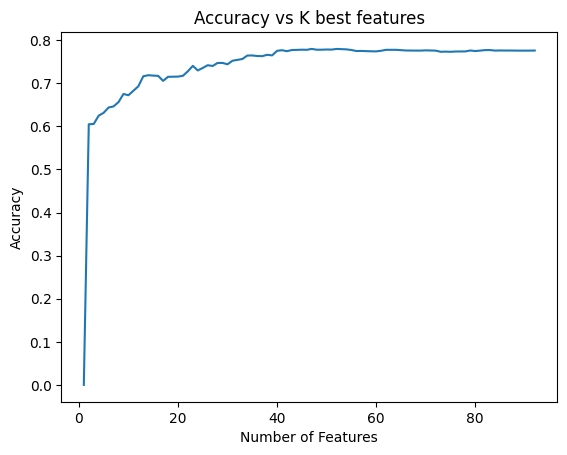

In [44]:
plt.figure()
x = np.linspace(1, 92, 92)
plt.plot(x, accuracy)
plt.title("Accuracy vs K best features")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.show()

## Recursive Feature Elemination (RFE)

In [45]:
estimator = LogisticRegression(max_iter=5000)
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(Xtrain, Ytrain)
ranks = selector.ranking_
indexes = [i for i in range(len(ranks)) if ranks[i] == 1]

In [46]:
print(f"Number of features selected by RFE: {len(indexes)}")

Number of features selected by RFE: 51


In [47]:
# Checking performance with 51 features selected by RFE
temp_train = Xtrain[:,indexes]
temp_test = Xtest[:,indexes]


clf = LogisticRegression(max_iter=5000)
clf.fit(temp_train, Ytrain)
preds = clf.predict(temp_test)
acc = accuracy_score(Ytest, preds)
print(f"Logistic regrssion accuracy with 51 best features: {acc*100:.3f}%")

Logistic regrssion accuracy with 51 best features: 77.638%


## Running RFE on 46 features selected by UFS

In [48]:
# Selecting the best 46 features that were given by UFS
fs = SelectKBest(score_func=chi2, k=46)
X_selected = fs.fit_transform(Xtrain, Ytrain)

imp_ind = np.argsort(-fs.scores_)

tempTrain = Xtrain[:,np.sort(imp_ind[:46])] 

In [49]:
# Running RFE on the 46 features selected by UFS to see if there is any futher
# feature selection possible to reduce the number further down from 46
estimator = LogisticRegression(max_iter=5000)
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(tempTrain, Ytrain)
ranks = selector.ranking_
ufs_rfe_ind = [i for i in range(len(ranks)) if ranks[i] == 1]

In [50]:
print(f"Number of UFS features selected by RFE: {len(ufs_rfe_ind)}")

Number of UFS features selected by RFE: 46


## Testing model performance on features common to both UFS and RFE

In [51]:
# Getting features that were commonly selected by both RFE and UFS
temp1 = imp_ind[:46]
temp2 = np.array(indexes)

temp3 = []
for i in temp2:
  if i in temp1:
    temp3.append(i)

temp3 = np.array(temp3)
print(f"Number of features common to UFS and RFE: {len(temp3)}")

Number of features common to UFS and RFE: 32


In [52]:
# Checking performance with 32 features common to both RFE and UFS
temp3Train = Xtrain[:,temp3]
temp3Test = Xtest[:,temp3]

clf = LogisticRegression(max_iter=5000)
clf.fit(temp3Train, Ytrain)
preds = clf.predict(temp3Test)
acc = accuracy_score(Ytest, preds)
print(f"Logistic Regression accuracy with features common to UFS and RFE: {acc*100:.3f}%")

Logistic Regression accuracy with features common to UFS and RFE: 75.804%


# Summary 2

- There were 46 features selected using UFS with chi2 statistic test
- There were 51 features selected using RFE
- There were 32 features common to both UFS and RFE
- Running RFE on 46 features selected by UFS did not further reduce the features, REF considered all 46 features
- Accuracy with 46 UFS features was 77.971%
- Accuracy with 51 RFE features was 77.638%
- Accuracy with 32 common features was 75.804%

Result of analysis: UFS method gave the lowest number of features with highest accuracy. The model used for accuracy measurement is logistic regression.

---

# Model Selection

In [116]:
Xtrain, Ytrain, Xtest, Ytest = pre_processing(df_train, df_test)

In [117]:
# Selecting the best 46 features that were given by UFS
# These will be the final train and test sets on which 
# we will run different models and see which one performs the best
fs = SelectKBest(score_func=chi2, k=46)
fs.fit(Xtrain, Ytrain)

imp_ind = np.argsort(-fs.scores_)

Xtrain = Xtrain[:,np.sort(imp_ind[:46])] 
Xtest = Xtest[:,np.sort(imp_ind[:46])]
Xtrain.shape, Xtest.shape

((42748, 46), (18321, 46))

## Logistic Regression

In [55]:
# Checking basic logistic regression 
clf = LogisticRegression(max_iter=1000)
clf.fit(Xtrain, Ytrain)
preds = clf.predict(Xtest)
acc = accuracy_score(Ytest, preds)
print(f"Accuracy of Logistic Regression: {acc*100:.3f}%")

Accuracy of Logistic Regression: 77.971%


Hyperparameter search via crossbalidation for Logistic Regression classifier

In [56]:
# Checking basic logistic regression to make sure everything so far is correct
clf = LogisticRegression(max_iter=1000)
accuracy_scores = []
num_folds = 5
kf = KFold(n_splits=num_folds)

for fold, (train_indices, val_indices) in enumerate(kf.split(Xtrain)):

      Xtrain_fold = Xtrain[train_indices]
      Ytrain_fold = Ytrain[train_indices]
      Xval_fold = Xtrain[val_indices]
      Yval_fold = Ytrain[val_indices]

      
      clf.fit(Xtrain_fold, Ytrain_fold)

      
      pred_val = clf.predict(Xval_fold)
      accuracy = accuracy_score(Yval_fold, pred_val)
      accuracy_scores.append(accuracy)

preds = clf.predict(Xtest)
acc = accuracy_score(Ytest, preds)
f1 = f1_score(preds, Ytest, average = 'binary')
print(f"Accuracy of Logistic Regression: {acc*100:.3f}%")
print(f'The F1 score of Logistic Regression:{f1*100}')

Accuracy of Logistic Regression: 77.965%
The F1 score of Logistic Regression:75.14927670052325


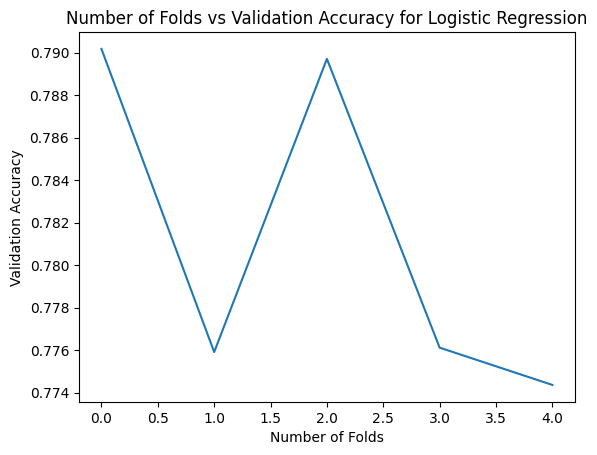

In [58]:
plt.plot(accuracy_scores)
plt.xlabel('Number of Folds')
plt.ylabel('Validation Accuracy')
plt.title('Number of Folds vs Validation Accuracy for Logistic Regression')
plt.show()

## SVM Classifier (Linear Kernel)

In [62]:
svm = SVC(kernel='linear', C=1.0)
svm.fit(Xtrain, Ytrain)
y_pred = svm.predict(Xtest)
accuracy = accuracy_score(Ytest, y_pred)
f1 = f1_score(Ytest, y_pred, average = 'binary')
print("Accuracy of SVM classifier with linear kernel:", accuracy)

Accuracy of SVM classifier with linear kernel: 0.7494678238087441


In [63]:
print(f'The F1 Score of the SVM Classifier (linear kernel) is {100*f1:.3f}%')

The F1 Score of the SVM Classifier (linear kernel) is 71.277%


## SVM classifier (RBF kernel)

In [64]:
# Testing non linear SVM classifier with RBF kernel
clf = NuSVC()
clf.fit(Xtrain, Ytrain)
preds = clf.predict(Xtest) 
acc = accuracy_score(Ytest, preds)
f1 = f1_score(Ytest, preds, average = 'binary')
print(f"Accuracy of nonlinear SVM classifier using RBF kernel: {acc*100:.3f}%")
print(f'The F1 Score of the SVM Classifier (RBF kernel) is {100*f1:.3f}%')

Accuracy of nonlinear SVM classifier using RBF kernel: 86.868%
The F1 Score of the SVM Classifier (RBF kernel) is 84.830%


Hyperparameter search via crossvalidation for SVM classifer with RBF kernel

In [120]:
gamma, accuracy_fold, accuracy_run, accuracy_test = radialSVC(Xtrain, Ytrain, Xtest, Ytest)

Best Accuracy of RBF Kernel: 98.766% for gamma = 1
F1 Score of RBF is:0.9860061919504645


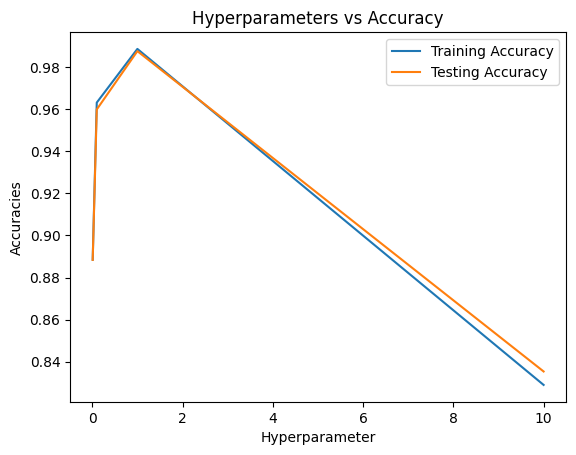

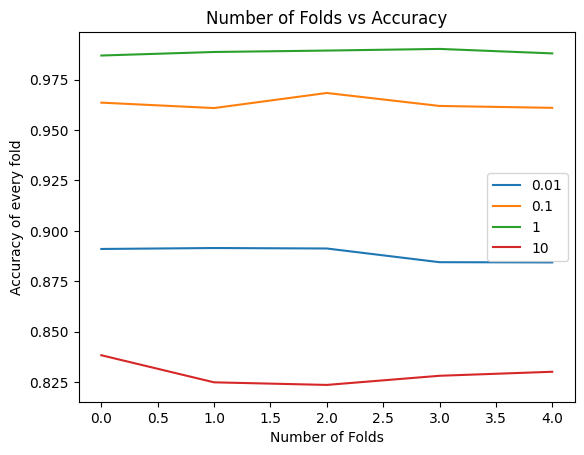

In [123]:
plot_fin(l1=gamma, accuracy_run=accuracy_run, accuracy_test=accuracy_test, accuracy_fold=accuracy_fold)

## K Nearest Neighbours Classifier

In [65]:
# Testing K Neighbors Classifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(Xtrain, Ytrain)
preds = neigh.predict(Xtest) 
acc = accuracy_score(Ytest, preds)
print(f"Accuracy of KNeighborsClassifier: {acc*100:.3f}%")

Accuracy of KNeighborsClassifier: 99.203%


Hyperparameter search via cross validation for K Neighbors Classifier

In [98]:
neighbors, accuracy_fold, accuracy_run, accuracy_test = knearest(Xtrain, Ytrain, Xtest, Ytest)

Best Accuracy of KNN Classifier: 99.236% for number of neighbors = 1
F1 Score of KNN is:0.99128160418483


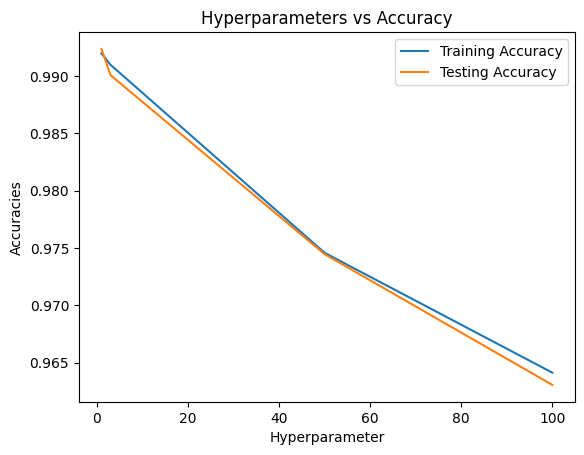

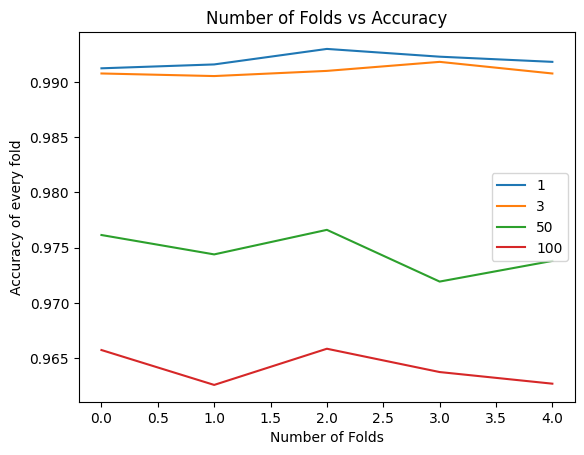

In [99]:
plot_fin(l1=neighbors, accuracy_run=accuracy_run, accuracy_test=accuracy_test, accuracy_fold=accuracy_fold)

## Multilayer Perceptron (ANN)

Hyperparameter search via crossvalidation for Multilayer Perceptron (MLP)

In [100]:
lr, accuracy_run, accuracy_test, accuracy_fold, f1_list = mlp_classifier(Xtrain,Ytrain,Xtest,Ytest,'sgd')

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perce

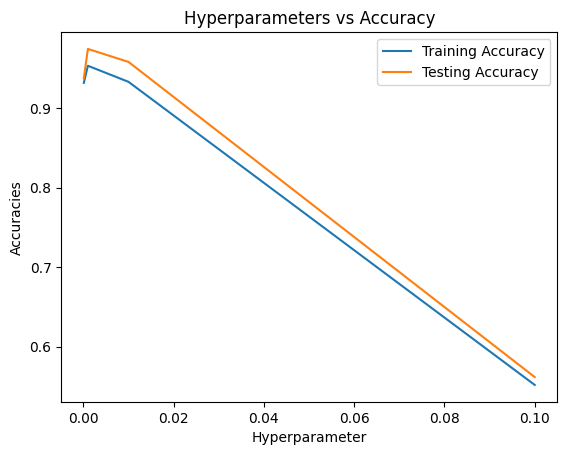

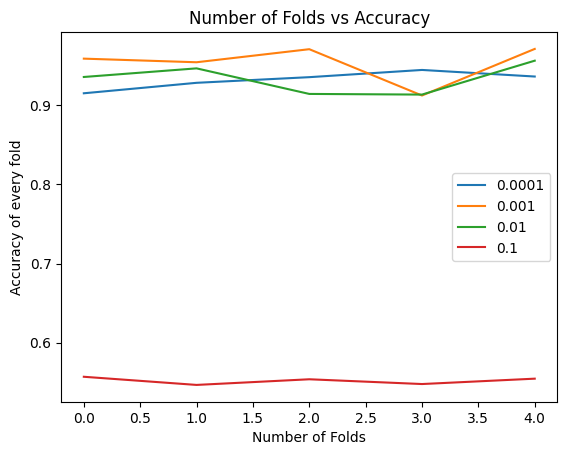

In [101]:
plot_fin(l1=lr, accuracy_run=accuracy_run, accuracy_test=accuracy_test, accuracy_fold=accuracy_fold)

In [102]:
print(f'The accuracy obtained is {max(accuracy_test)*100} with learning rate = {lr[np.argmax(np.array(accuracy_test))]} and F1 Score = {f1_list[np.argmax(np.array(accuracy_test))]} for SGD')

The accuracy obtained is 97.45101249931773 with learning rate = 0.001 and F1 Score = 0.9708616709303051 for SGD


In [103]:
lr, accuracy_run, accuracy_test, accuracy_fold, f1_list = mlp_classifier(Xtrain,Ytrain,Xtest,Ytest,'adam')

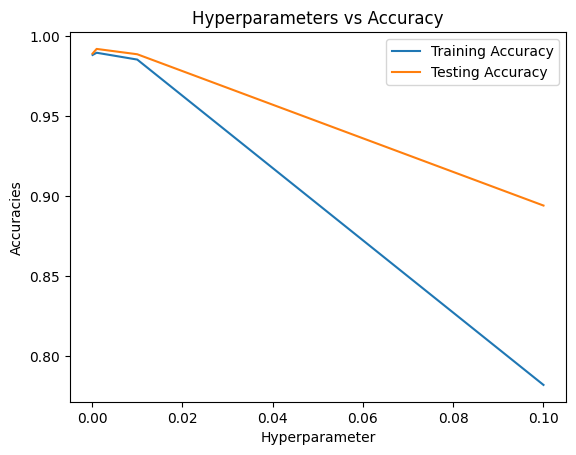

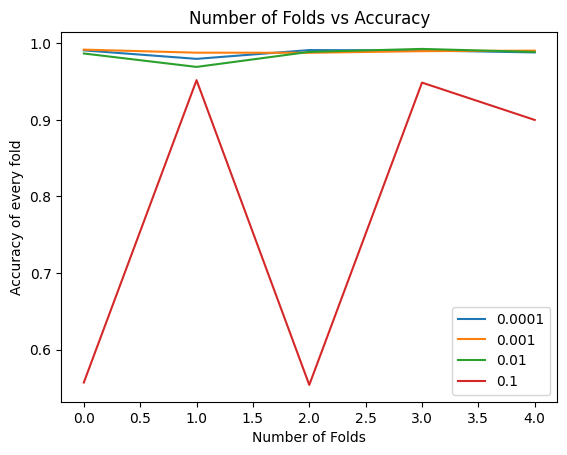

In [104]:
plot_fin(l1=lr, accuracy_run=accuracy_run, accuracy_test=accuracy_test, accuracy_fold=accuracy_fold)

In [105]:
print(f'The accuracy obtained is {max(accuracy_test)*100} with learning rate = {lr[np.argmax(np.array(accuracy_test))]} for adam')

The accuracy obtained is 99.1812673980678 with learning rate = 0.001 for adam


# Random Forest Classifier

In [106]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(Xtrain, Ytrain)
y_pred = rfc.predict(Xtest)
accuracy = accuracy_score(y_pred, Ytest)
print(f'The accuracy of the Random Forest Classifier is {100*accuracy:.3f}%')
f1 = f1_score(Ytest, y_pred, average = 'binary')
print(f'The F1 Score of the Random Forest Classifier is {100*f1:.3f}%')

The accuracy of the Random Forest Classifier is 99.602%
The F1 Score of the Random Forest Classifier is 99.545%


Hyperparameter search via crossvalidation for Random Forest Classifier

In [107]:
n_estim, accuracy_run, accuracy_fold, accuracy_test, f1_list = random_forest(Xtrain, Ytrain, Xtest, Ytest)

In [108]:
print(f'The accuracy obtained is {max(accuracy_test)*100} with n_estim = {n_estim[np.argmax(np.array(accuracy_run))]}')

The accuracy obtained is 99.53059330822553 with n_estim = 100


In [109]:
print(f'The f1 Score obtained is {f1_list[np.argmax(np.array(accuracy_run))]*100}')

The f1 Score obtained is 99.46397407130392


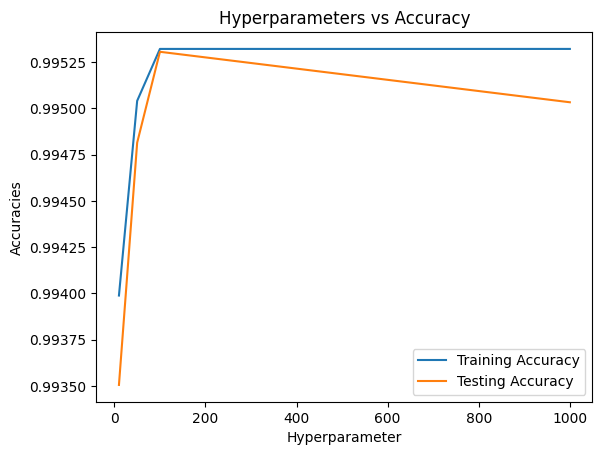

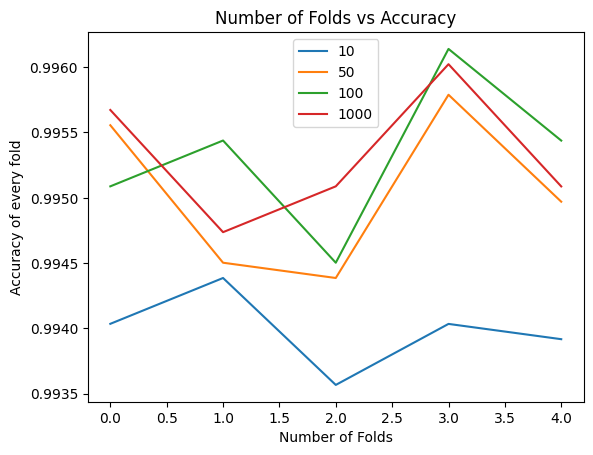

In [110]:
plot_fin(l1=n_estim, accuracy_run=accuracy_run, accuracy_test=accuracy_test, accuracy_fold=accuracy_fold)

# Common Features of Poisonous Mushrooms

In [118]:
# Best model outside scope of EE559 
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(Xtrain, Ytrain)
preds = rfc.predict(Xtest)
accuracy = accuracy_score(preds, Ytest)
print(f'The accuracy of the Random Forest Classifier is {100*accuracy:.3f}%')
f1 = f1_score(Ytest, preds, average = 'binary')
print(f'The F1 Score of the Random Forest Classifier is {100*f1:.3f}')

The accuracy of the Random Forest Classifier is 99.602%
The F1 Score of the Random Forest Classifier is 99.545


In [119]:
top3feats_of_poison_mushrooms(Xtest[:,:43], preds, imp_ind[:46], df_train)

{0: ['cap-shape', 'o'], 1: ['stem-color', 'r']}
{0: ['gill-attachment', 'p'], 1: ['habitat', 'w']}
{0: ['cap-surface', 'h'], 1: ['gill-attachment', 'p'], 2: ['does-bruise-or-bleed', 'a'], 3: ['stem-color', 'b'], 4: ['ring-type', 'l'], 5: ['cap-color', 'l']}


---
We can say that if a mushroom satisfies more than 1 of the following properties:

- cap-shape	: o
- stem-color : r/b
- gill-attachment :	p
- habitat	: w
- cap-surface	: h
- does-bruise-or-bleed :	a
- ring-type	: l
- cap-color	: l

then it can be assumed to be posionous

---


